# Equalizers Quickstart
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/remifan/commplax/blob/master/docs/tutorial/equalizers.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/remifan/commplax/HEAD?filepath=docs%2Ftutorual%2Fequalizers.ipynb)

In [1]:
# Install commplax if not found (for refresh rumtime in colab).

try:
  import commplax
except:
  # Jax
  !pip install --upgrade pip
  !pip install --upgrade jax==0.2.13 jaxlib==0.1.66+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html # optional GPU lib
  # commplax
  !pip install http://github.com/remifan/commplax/archive/master.zip

## A minimal example of blind demodulation

In [2]:
import numpy as np
import zarr
import matplotlib.pyplot as plt
from commplax import comm, xcomm, equalizer as eq, plot as cplt

### Load dataset
let's get started with one of our public datasets -- experimental transmission of DP-16QAM siganl over ~815km SSMF 

see [LabPtPTm1](https://github.com/remifan/LabPtPTm1) for more information

In [3]:
dat = zarr.open_group("simplecache::s3://optcommpubdataqrfan/labptptm1_zarr",
                      storage_options={"s3": {'anon': True}})

In [4]:
ds = dat['815km_SSMF/DP16QAM_RRC0.2_28GBd_1ch']

y = ds['LP-6_5/recv'][:200000]
x = dat['source/16QAM65536/src'][:]
sr = ds.attrs['samplerate']
br = ds.attrs['baudrate']
dist = ds.attrs['distance']
spans = ds.attrs['spans']
mf = ds.attrs['modformat']
lpw = ds['LP-6_5'].attrs['lpw']
         
# meta data
print('shape of y: %s (received waveforms, resampled to 2 samples/symbol): ' % str(y.shape))
print('shape of x: %s (source symbols): ' % str(x.shape))
print('sample rate: %.1f GHz' % (sr / 1e9))
print('baud rate: %.1f GBd' % (br / 1e9))
print('launched power: %.3f mW' % (lpw * 1e3))
print('link distance: %.1f km (measured)' % (dist / 1e3))
print('number of spans: %d' % spans)

shape of y: (200000, 2) (received waveforms, resampled to 2 samples/symbol): 
shape of x: (65536, 2) (source symbols): 
sample rate: 56.0 GHz
baud rate: 28.0 GBd
launched power: 0.871 mW
link distance: 815.0 km (measured)
number of spans: 10


### Preprocessing

In [5]:
# DC-block and normalize raw signal
y -= np.mean(y, axis=0)
y =  xcomm.normpower(y, real=True) / np.sqrt(2)
 
# CD measurement, which runs much faster in GPU
# CD = 13.6
CD = xcomm.measure_cd(y[10000:30000, 0], sr, bins=2000)[0]
print('estimated accumulated CD = %.4g s/m' % CD)

estimated accumulated CD = 13.6 s/m


### Adaptive equalization using `commplax.equalizer` APIs

In [6]:
z_cdc = eq.cdcomp(y, sr, CD)  # CD compensaton

In [7]:
z_mimo = eq.modulusmimo(z_cdc, taps=19, lr=2**-14)[0]  # polarization demultiplexing

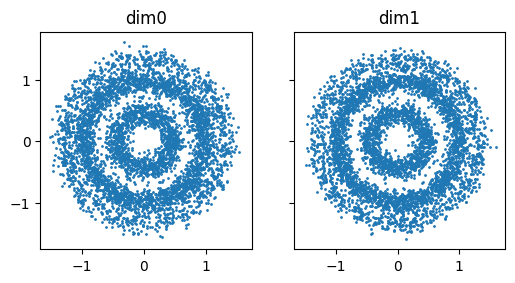

In [8]:
cplt.scatter(z_mimo[90000:95000])

In [9]:
z_foe = eq.qamfoe(z_mimo)[0]  # frequency offset equalization

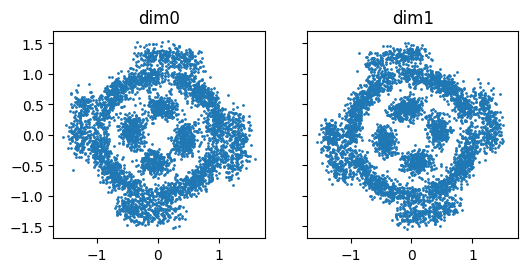

In [10]:
cplt.scatter(z_foe[90000:95000])

In [11]:
z_cpr = eq.ekfcpr(z_foe)[0]  # carrier phase recovery

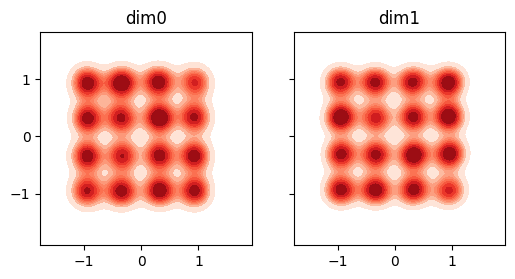

In [12]:
cplt.scatter(z_cpr[90000:95000], kde=True) # kdeplot takes more time

In [13]:
# aligning sent symbols to calc. BER
x_rep = xcomm.repalign(z_cpr, x)

# removing phase ambiguity and rescale signal
x_hat = xcomm.alignphase(z_cpr, x_rep) * xcomm.qamscale(mf)

# get metrics
qot = comm.qamqot(x_hat, x_rep, eval_range=(50000, -1000))
qot

,BER,QSq,SNR
dim0,0.001107,9.714077,16.516765
dim1,0.000449,10.424561,17.383057
total,0.000778,10.004753,16.928391
